In [1]:
import Dates
println("Last updated: ", Dates.now(), " (PT)")

Last updated: 2020-07-01T16:34:08.294 (PT)


In [2]:
# Load environment
import Pkg; Pkg.activate("../../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


In [3]:
# Import Libraries
using Turing
using Turing: Variational
import Turing.RandomMeasures.DirichletProcess
import Turing.RandomMeasures.ChineseRestaurantProcess
using Distributions
using JSON3
using PyPlot
using StatsFuns
import Random
using BenchmarkTools
using Flux
import StatsBase.countmap
include(joinpath(@__DIR__, "../util/BnpUtil.jl"));

In [4]:
# Directory where all simulation data are stored.
data_dir = joinpath(@__DIR__, "../../data/sim-data")
path_to_data = joinpath(data_dir, "gmm-data-n50.json")

# Load data in JSON format.
data = let
    x = open(f -> read(f, String), path_to_data)
    JSON3.read(x, Dict{Symbol, Vector{Any}})
end

Dict{Symbol,Array{Any,1}} with 5 entries:
  :w        => Any[0.220078, 0.291918, 0.2498, 0.238204]
  :mu       => Any[-1.47027, -0.46176, 0.440237, 1.49896]
  :sig      => Any[0.148861, 0.121097, 0.195192, 0.19999]
  :y        => Any[-0.564699, -0.324993, -0.625064, -1.28564, -0.468499, -1.357…
  :rand_idx => Any[2, 2, 2, 1, 2, 1, 4, 4, 2, 4  …  2, 4, 3, 2, 1, 3, 4, 3, 2, …

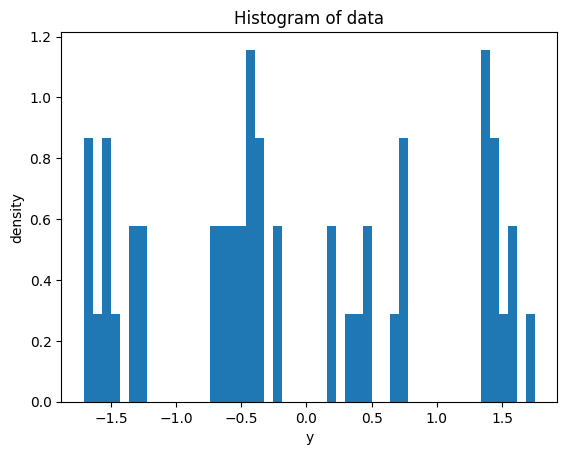

In [5]:
# Convert data to vector of floats
y = Float64.(data[:y]);

# Visualize data
plt.hist(y, bins=50, density=true)
plt.xlabel("y")
plt.ylabel("density")
plt.title("Histogram of data");

In [6]:
function extract(chain, sym; burn=0)
    tail  = chain[sym].value.data[(burn + 1):end, :, :]
    return dropdims(tail, dims=3)
end

extract (generic function with 1 method)

In [139]:
# DP GMM model under CRP construction
@model dp_gmm_crp(y) = begin
    nobs = length(y)
    
    alpha ~ Gamma(1, 0.1)  # mean = a/b
    rpm = DirichletProcess(alpha)
    
    # Base measure.
    # H = arraydist([Normal(0, 3), Gamma(1, 1/10)])
    
    # Latent assignment.
    z = zeros(Int, nobs)
    
    # Locations and scales of infinitely many clusters.
    # mu_sigma = Vector{Float64}[]
    Kmax = 10
    mu_sigma ~ arraydist([Normal.(zeros(Kmax), 3) InverseGamma.(2*ones(Kmax), 0.05)])
    
    for i in 1:nobs
        # Number of clusters.
        K = maximum(z)
        n = [sum(z .== k) for k in 1:K]
        
        # Sample cluster label.
        z[i] ~ ChineseRestaurantProcess(rpm,  n)
        
        # Create a new cluster.
        # if z[i] > K
        #     push!(mu_sigma, [0.0, 0.1])
        #     mu_sigma[z[i]] ~ H
        # end
        
        # Sampling distribution.
        # mu, sigma = mu_sigma[z[i]]
        mu, sigma = mu_sigma[z[i], :]
        y[i] ~ Normal(mu, sigma)
    end
end
;

In [140]:
# Set random seed for reproducibility
Random.seed!(5);

# Compile time approx. 32s.
# Run time approx. 70s

@time chain = begin
    burn = 1000  # NOTE: The burn in is also returned. Can't be discarded.
    n_samples = 1000
    iterations = burn + n_samples

    sample(dp_gmm_crp(y), SMC(100), iterations)
end;

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


 13.320021 seconds (37.94 M allocations: 3.470 GiB, 16.57% gc time)


In [141]:
chain.name_map
chain.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 1:1:2000
    :var, ["alpha", "le", "lp", "mu_sigma[1, 1]", "mu_sigma[1, 2]", "mu_sigma[2, 1]", "mu_sigma[2, 2]", "mu_sigma[3, 1]", "mu_sigma[3, 2]", "mu_sigma[4, 1]"  …  "z[41]", "z[42]", "z[43]", "z[44]", "z[45]", "z[46]", "z[47]", "z[48]", "z[49]", "z[50]"]
    :chain, 1:1
And data, a 2000×74×1 Array{Float64,3}:
[:, :, 1] =
 0.203731  -102.649  0.0  -0.501289  …  1.0  2.0  2.0  2.0  2.0  1.0  2.0
 0.203731  -102.649  0.0  -0.501289     1.0  2.0  2.0  2.0  2.0  1.0  2.0
 0.203731  -102.649  0.0  -0.501289     1.0  2.0  2.0  2.0  2.0  1.0  2.0
 0.203731  -102.649  0.0  -0.501289     1.0  2.0  2.0  2.0  2.0  1.0  2.0
 0.203731  -102.649  0.0  -0.501289     1.0  2.0  2.0  2.0  2.0  1.0  2.0
 0.203731  -102.649  0.0  -0.501289  …  1.0  2.0  2.0  2.0  2.0  2.0  2.0
 0.203731  -102.649  0.0  -0.501289     1.0  2.0  2.0  2.0  2.0  2.0  2.0
 0.203731  -102.649  0.0  -0.501289     1.0  2.0  2.0  2.0  2.0  2.0  2.0
 0.203731  -102.649

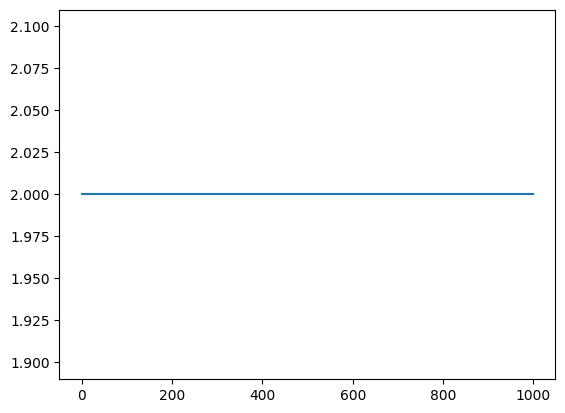

In [142]:
z = chain.value.data[end-burn+1:end, (end-length(y)+1):end, 1]
nclus = [length(unique(z[i, :])) for i in 1:size(z, 1)];
plt.plot(nclus);

In [143]:
chain.value.data[:, 4:10, 1]

2000×7 Array{Float64,2}:
 -0.501289  0.0863799  -0.259518  1.85209  -5.16881  0.0132527  2.83951
 -0.501289  0.0863799  -0.259518  1.85209  -5.16881  0.0132527  2.83951
 -0.501289  0.0863799  -0.259518  1.85209  -5.16881  0.0132527  2.83951
 -0.501289  0.0863799  -0.259518  1.85209  -5.16881  0.0132527  2.83951
 -0.501289  0.0863799  -0.259518  1.85209  -5.16881  0.0132527  2.83951
 -0.501289  0.0863799  -0.259518  1.85209  -5.16881  0.0132527  2.83951
 -0.501289  0.0863799  -0.259518  1.85209  -5.16881  0.0132527  2.83951
 -0.501289  0.0863799  -0.259518  1.85209  -5.16881  0.0132527  2.83951
 -0.501289  0.0863799  -0.259518  1.85209  -5.16881  0.0132527  2.83951
 -0.501289  0.0863799  -0.259518  1.85209  -5.16881  0.0132527  2.83951
 -0.501289  0.0863799  -0.259518  1.85209  -5.16881  0.0132527  2.83951
 -0.501289  0.0863799  -0.259518  1.85209  -5.16881  0.0132527  2.83951
 -0.501289  0.0863799  -0.259518  1.85209  -5.16881  0.0132527  2.83951
  ⋮                                    

In [144]:
function counts_plot(x; density=false, color="C0", lw=4)
    cm_x = countmap(x)
    number = collect(keys(cm_x))
    count = let
        c = collect(values(cm_x))
        density ? c / sum(c) : c
    end
    plt.vlines(number, 0, count, color=color, lw=lw)
end

counts_plot (generic function with 1 method)

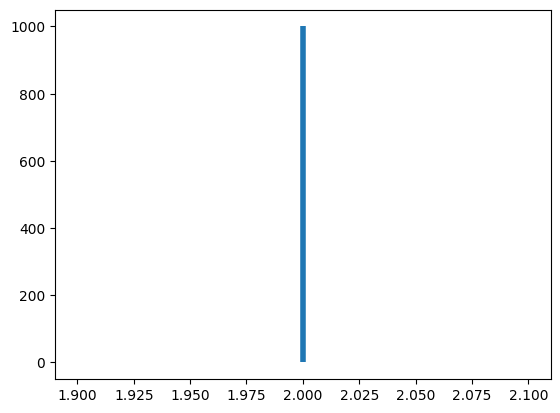

In [145]:
counts_plot(nclus);

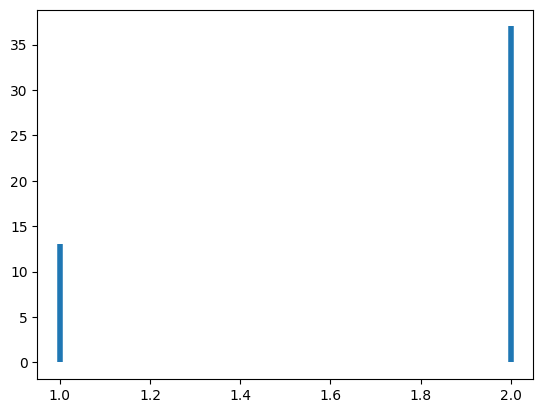

PyObject <matplotlib.collections.LineCollection object at 0x7f26d35354e0>

In [146]:
counts_plot(z[10, :])